## 任务说明
实现并评估基于网格表示的transfomer模型，用于对图像生成对应的文本描述

## 实验数据
基本的数据集使用课程提供的DeepFashion-MultiModal数据集，包含了对应的图像和文本描述

## 实验环境
- 操作系统： 22.04.1-Ubuntu x86_64 内核6.2.0-39-generic
- GPU: NVIDIA GeForce RTX 3060 laptop GPU
- CUDA: 12.2
- python: conda-python 3.11.5
- pytorch: 2.1.1

In [1]:
from cgi import test
import os
from collections import Counter
import numpy as np
import json
import torch
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

/tmp/ipykernel_24904/508661157.py:1: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  from cgi import test
/home/dnull/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 数据预处理阶段

## 建立数据集类

In [2]:
image_path = "./data/deepfashion-multimodal/images/"
train_text = "./data/deepfashion-multimodal/train_captions.json"
test_text = "./data/deepfashion-multimodal/test_captions.json"

class MyDataset(Dataset):
    def __init__(self, image_paths, train_captions, test_captions, transform=None):
        self.image_paths = image_paths
        self.train_captions = train_captions
        self.test_captions = test_captions
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        idx_name = self.image_paths[idx]
        file_name = idx_name.split("/")[-1]
        image = Image.open(idx_name).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.train_captions[file_name]
    
    def get_train_captions(self):
        return self.train_captions

## 读取数据集文本并建立图片的transform

In [3]:
# read data
train_captions = json.load(open(train_text, 'r'))
test_captions = json.load(open(test_text, 'r'))
image_paths = []
# add from train_captions
for key in train_captions.keys():
    image_paths.append(image_path + key)

transform = transforms.Compose(
    [
        transforms.Resize((256 * 4, 256 * 4)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

## 对文本描述进行编码

这一步将文本描述的每一个单词映射到一个整数, 并用一个整数序列来表示原本的文本描述

具体的执行步骤如下:

- 建立一个词典vocab, 用于将单词映射到整数
- 将0映射为占位符<pad>
- 将len(vocab)映射为未知单词<start>
- 将len(vocab)+1映射为结束符<end>
- 将原本的句子按照空格分割, 开头结尾加上<start>和<end>
- 用<pad>将句子补齐到最大长度
- 将句子中的每一个单词映射到整数

In [4]:
image_dic = train_captions.keys()
image_descriptions = train_captions.values()

# build vocabulary
vocab = Counter()
for description in image_descriptions:
    vocab.update(description.split())

# remove words that occur less than threshold
threshold = -1
words = [word for word, count in vocab.items() if count >= threshold]

# create a mapping from word to index and index to word
idx_to_word = {idx: word for idx, word in enumerate(words, 1)}

# add the start and end token to the vocabulary
idx_to_word[0] = "<pad>"
idx_to_word[len(idx_to_word)] = "<end>"
idx_to_word[len(idx_to_word)] = "<start>"

# add the end to the end pos
for key, description in train_captions.items():
    train_captions[key] = "<start> " + description + " <end>"

# pad the descriptions with <pad>
max_length = max(len(description.split()) for description in image_descriptions)
for key, description in train_captions.items():
    train_captions[key] = description + " <pad>" * (
        max_length - len(description.split())
    )
for key, description in test_captions.items():
    test_captions[key] = description + " <pad>" * (
        max_length - len(description.split())
    )

word_to_idx = {word: idx for idx, word in idx_to_word.items()}
vocab_size_len = len(idx_to_word)


# convert each word to its index
train_captions = {
    key: [word_to_idx[word] for word in value.split()]
    for key, value in train_captions.items()
}
test_captions = {
    key: [word_to_idx[word] for word in value.split()]
    for key, value in test_captions.items()
}


for key, value, idx in zip(train_captions.keys(), train_captions.values(), range(5)):
    print(key, value, idx)
    if idx == 4:
        break


WOMEN-Jackets_Coats-id_00005611-01_4_full.jpg [159, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 13, 14, 15, 16, 17, 1, 18, 3, 16, 14, 5, 19, 1, 8, 16, 20, 9, 15, 4, 10, 11, 12, 21, 22, 23, 24, 25, 26, 27, 28, 7, 8, 9, 29, 12, 21, 30, 16, 31, 32, 33, 34, 35, 36, 21, 30, 4, 37, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 0
WOMEN-Tees_Tanks-id_00005033-03_4_full.jpg [159, 38, 39, 40, 4, 41, 6, 42, 8, 9, 43, 12, 44, 4, 32, 45, 46, 1, 47, 24, 32, 5, 48, 1, 49, 50, 28, 20, 8, 9, 10, 11, 12, 1, 22, 24, 32, 51, 158, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 1
WOMEN-Rompers_Jumpsuits-id_00000245-01_1_front.jpg [159, 38, 39, 52, 4, 41, 6, 7, 8, 9, 10, 11, 12, 44, 4, 32, 53, 46, 21, 54, 24, 32, 5, 55, 1, 56, 50, 28, 7, 8, 9, 10, 11, 12, 57, 16, 32, 33, 34, 35, 36, 1, 22, 24, 32, 58, 57, 16, 25, 59, 34, 35, 60, 158, 0, 

## 建立数据集

In [5]:
for key, value in train_captions.items():
    train_captions[key] = torch.tensor(value, dtype=torch.long)

# make dataset
dataset = MyDataset(image_paths, train_captions, test_captions, transform)

for i in range(1):
    print(dataset[i][0].shape, dataset[i][1].shape)
    print(dataset[i][0], dataset[i][1])

torch.Size([3, 1024, 1024]) torch.Size([95])
tensor([[[0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [0.9686, 0.9686, 0.9686,  ..., 0.9216, 0.9216, 0.9216],
         [0.9686, 0.9686, 0.9686,  ..., 0.9216, 0.9216, 0.9216],
         [0.9686, 0.9686, 0.9686,  ..., 0.9294, 0.9294, 0.9294]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9843, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         ...,
         [0.9529, 0.9529, 0.9529,  ..., 0.9059, 0.9059, 0.9059],
         [0.9529, 0.9529, 0.9529,  ..., 0.9059, 0.9059, 0.9059],
         [0.9529, 0.9529, 0.9529,  ..., 0.9216, 0.9216, 0.9216]],

        [[0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9922, 0.9922, 0.9922,  ..., 0.9686, 0.9686, 0.9686],
         [0.9

## 定义模型

模型分为两个主要部分:
- resnet18
- transformer

### resnet18
resnet18能够刚好提取512维的特征, 这是transformer的嵌入维度的常用数值, 所以我们选择该模型作为图像特征提取器, 并使用

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.nn import Transformer

# 1. 使用预训练的 CNN 提取特征
class FeatureExtractorCNN(nn.Module):
    def __init__(self):
        super(FeatureExtractorCNN, self).__init__()
        
        self.resnet = models.resnet18(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])

    def forward(self, images):
        # resize to 3 times larger
        batch_size = images.shape[0]

        images = images.unfold(2, 256, 256).unfold(3, 256, 256)
        images = images.contiguous().view(-1, 3, 256, 256)

        # 提取特征
        features = self.resnet(images)
        features = features.view(batch_size, 16, -1)
        return features

# 2. 构建 Transformer 模型
class ImageCaptioningTransformer(nn.Module):
    def __init__(self, emb_dim, nhead, nhid, nlayers, vocab_size, max_seq_length):
        super(ImageCaptioningTransformer, self).__init__()
        self.pos_encoder = PositionalEncoding(emb_dim)
        self.transformer = Transformer(
            d_model=emb_dim,
            nhead=8,
            dim_feedforward=1024,
            num_encoder_layers=1,
            num_decoder_layers=1,
            batch_first=False,
            dropout=0,
            bias=True,
        )
        self.decoder = nn.Linear(emb_dim, vocab_size)
        self.max_seq_length = max_seq_length
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.cnn = FeatureExtractorCNN()
        
        self.trg_mask = None

    def forward(self, src, tgt, src_mask=None, tgt_mask=None, src_padding_mask=None,
                tgt_padding_mask=None, memory_mask=None):
        if self.trg_mask is None or self.trg_mask.size(0) != len(tgt):
            self.trg_mask = self.generate_square_subsequent_mask(len(tgt)).to(tgt.device)

        trg_pad_mask = self.make_len_mask(tgt)
        
        # output = self.encode(src, src_mask=src_mask, src_padding_mask=src_padding_mask)
        output = self.cnn(src).transpose(0, 1)
        print(output)
        output = self.decode(tgt, output, tgt_mask=self.trg_mask, tgt_key_padding_mask=trg_pad_mask,
                                memory_mask=memory_mask, memory_key_padding_mask=src_padding_mask)
        return output
    
    def generate_square_subsequent_mask(self, sz):
        mask = torch.triu(torch.ones(sz, sz), 1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def make_len_mask(self, inp):
        return (inp == 0).transpose(0, 1)
    
    def encode(self, src, src_mask=None, src_padding_mask=None):
        src = self.pos_encoder(src)  # 添加位置编码
        memory = self.transformer.encoder(src, mask=src_mask, src_key_padding_mask=src_padding_mask)
        return memory
    
    def decode(self, tgt, memory, tgt_mask=None, memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        if self.trg_mask is None or self.trg_mask.size(0) != len(tgt):
            device = tgt.device
            self.trg_mask = self.generate_square_subsequent_mask(len(tgt)).to(device)

        tgt = self.embedding(tgt)
        tgt = self.pos_encoder(tgt)
        output = self.transformer.decoder(tgt, memory, tgt_mask=self.trg_mask,
                                          tgt_key_padding_mask=tgt_key_padding_mask,
                                          memory_mask=memory_mask,
                                          memory_key_padding_mask=memory_key_padding_mask)
        output = self.decoder(output)
        return output

# 辅助类：位置编码
import torch
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # 创建位置编码
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return self.dropout(x)

In [7]:
# 逐词生成描述
def generate_caption(model, image_features, word2idx, idx2word,  max_length=93):

    outputs = [word2idx["<start>"]]

    for i in range(max_length - 1):
        
        with torch.no_grad():
            
            out = model(image_features, torch.tensor(outputs).unsqueeze(1).to(device))
        
        next_word = out.argmax(dim=2)[-1].item()

        # 检查是否达到结束标记
        if next_word == word2idx['<end>']:
            break  # 一旦生成<end>标记，立即停止生成
        
        # rand select next word from the top 1
        next_word = torch.topk(out, 5, dim=2)[1][-1].squeeze().tolist()
        # print next_word map to words
        #print([idx2word[idx] for idx in next_word])
        next_word = next_word[0]

        outputs.append(next_word)

    # 转换序列为文字
    caption = [idx2word[idx] for idx in outputs]

    return ' '.join(caption)

In [8]:
# 定义模型参数
emb_dim = 512  # 嵌入维度
nhead = 8  # 多头注意力的头数
nhid = 512  # 前馈网络的维度
nlayers = 1  # 编码器和解码器层的数量
vocab_size = vocab_size_len  # 词汇表大小
max_seq_length = 512  # 最大序列长度

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 创建模型实例
transformer = ImageCaptioningTransformer(
    emb_dim, nhead, nhid, nlayers, vocab_size, max_seq_length
).to(device)

print(transformer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4)

/home/dnull/miniconda3/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/dnull/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dnull/miniconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the m

ImageCaptioningTransformer(
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0, inplace=False)
          (dropout2): Dropout(p=0, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList

In [9]:
transformer = transformer.to(device)

# train
epoch = 5

optimizer = torch.optim.Adam(transformer.parameters(), 0.001)

vocab_size = vocab_size_len

# 使用权重创建损失函数
criterion = nn.CrossEntropyLoss(ignore_index=0)

for e in range(epoch):
    for i, (image, caption) in enumerate(dataloader):
        transformer.eval()
        
        
        caption = caption.to(device)
        
        optimizer.zero_grad()
        # 提取图像特征
        
        caption = caption.transpose(0, 1)
        
        loss = 0
        
        output = None
        
        #check each pos
        temp = 0
        pad_num = 0
        pad_num_2 = 0
        
        # split caption from length 2 to max_length
        output = transformer(image.to(device), caption[:-1, :])
        
        loss = criterion(output.reshape(-1, 160), caption[1:, :].reshape(-1))
        
        if i % 20 == 0:
            print("epoch: {}, step: {}, loss: {}".format(e, i, loss))
                
        loss.backward()
        optimizer.step()
        
    torch.save(transformer.state_dict(), "./model/transformer_thd{}.pth".format(e+2))

tensor([[[9.2642e-01, 3.5938e-01, 4.9268e-01,  ..., 6.2903e-01,
          1.7267e-01, 3.0945e-01],
         [1.2536e+00, 2.3886e-01, 8.9404e-01,  ..., 1.4898e+00,
          5.5198e-01, 1.8142e+00],
         [1.4984e+00, 3.5920e-01, 6.7345e-01,  ..., 1.4339e+00,
          5.6420e-02, 2.0158e+00],
         ...,
         [1.5430e+00, 5.5584e-01, 2.1890e+00,  ..., 1.9597e+00,
          1.0102e-01, 1.1617e+00],
         [1.0737e+00, 3.5768e-01, 7.7304e-01,  ..., 2.1750e+00,
          1.1647e-02, 4.9427e-01],
         [1.6713e+00, 7.8198e-01, 1.1046e+00,  ..., 1.6514e+00,
          5.5591e-02, 1.5580e+00]],

        [[1.9390e-01, 2.4423e-01, 4.0264e-01,  ..., 1.7310e+00,
          1.0754e+00, 8.0541e-01],
         [4.7994e-02, 2.5986e-03, 1.0280e-01,  ..., 7.7966e-01,
          4.4511e-01, 6.1506e-01],
         [4.7200e-01, 1.9557e-01, 4.3921e-01,  ..., 1.9566e+00,
          9.0168e-02, 3.3173e-01],
         ...,
         [1.3696e-01, 1.2919e-01, 2.0478e-01,  ..., 1.6373e+00,
          1.139

/home/dnull/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


epoch: 0, step: 0, loss: 5.306034088134766
tensor([[[3.4597e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3690e+00,
          7.2188e+00, 6.3429e-01],
         [4.1183e+00, 0.0000e+00, 0.0000e+00,  ..., 9.1411e-01,
          8.6878e+00, 1.2913e+00],
         [3.4836e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5643e+00,
          7.8588e+00, 1.2455e+00],
         ...,
         [4.5535e+00, 0.0000e+00, 0.0000e+00,  ..., 1.3333e+00,
          6.6111e+00, 7.9888e-01],
         [3.7110e+00, 0.0000e+00, 0.0000e+00,  ..., 1.4270e+00,
          7.7784e+00, 1.2129e+00],
         [3.6850e+00, 0.0000e+00, 0.0000e+00,  ..., 1.5368e+00,
          8.5162e+00, 7.7721e-01]],

        [[3.2819e+00, 0.0000e+00, 0.0000e+00,  ..., 2.6754e+00,
          4.8319e+00, 1.4571e-01],
         [4.4904e+00, 0.0000e+00, 0.0000e+00,  ..., 1.1623e+00,
          8.4242e+00, 3.6126e-01],
         [3.4545e+00, 0.0000e+00, 0.0000e+00,  ..., 1.2870e+00,
          7.0327e+00, 9.1128e-01],
         ...,
         [3.4834e+00, 0.0000e+00, 0.

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 1024, 1024]) torch.Size([95])


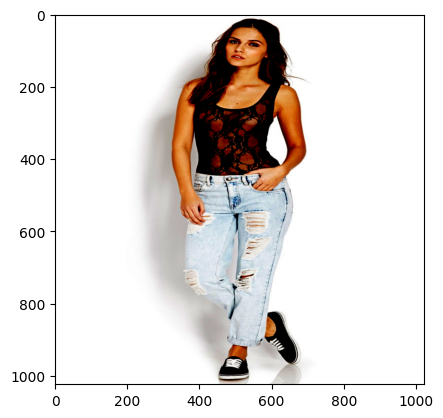

tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

    

/home/dnull/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.]],

    

In [10]:
import matplotlib.pyplot as plt

test_data = dataset[1]
print(test_data[0].shape, test_data[1].shape)

test_image = test_data[0].unsqueeze(0).to(device)

transformer.load_state_dict(torch.load("./model/transformer_thd3.pth"))
transformer.eval()

# show the img
plt.imshow(test_data[0].permute(1, 2, 0).numpy())
plt.show()

output = generate_caption(transformer, test_image, word_to_idx, idx_to_word)

# output = transformer(test_feature, test_feature, None, None, None, None)

print(output)

caption = test_data[1].numpy()
sentence = ""
for idx in caption:
    if idx == 0:
        continue
    sentence += idx_to_word[idx.item()] + " "
    
print(sentence)

# idx2word
idx2word = {idx: word for idx, word in enumerate(words, 1)}
idx2word[0] = "<pad>"
idx2word[len(idx2word)] = "<end>"

In [ ]:
transformer.eval()
test_data = json.load(open(test_text, 'r'))

test_image_paths = []
# add from train_captions
for key in test_data.keys():
    test_image_paths.append(image_path + key)
    
res = {}
    
for i, path in enumerate(test_image_paths):
    if i == 620:
        break
    
    test_image = Image.open(path).convert("RGB")
    test_image = transform(test_image).unsqueeze(0).to(device)
    test_feature = cnn(test_image)
    
    test_feature = test_feature.transpose(0, 1)
    
    output = generate_caption(transformer, test_feature, word_to_idx, idx_to_word)
    
    # remove start
    output = output.split(" ")
    output = output[1:]
    output = " ".join(output)
    
    res[path.split("/")[-1]] = output
    
json.dump(res, open("./result2.json", 'w'))

/home/dnull/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
import evaluate
import json
import numpy as np

test_text = "./data/deepfashion-multimodal/test_captions.json"

# read from result.json
test_data = json.load(open("./result.json", 'r'))
real_data = json.load(open(test_text, 'r'))

test_selected_data = {}
real_selected_data = {}

indice = 0
for key, value in test_data.items():
    real_selected_data[key] = real_data[key]
    test_selected_data[key] = value
    indice += 1

eval = evaluate.DeepFashionEvalCap(real_selected_data, test_selected_data)
eval.evaluate()

Setting up scorers...
Calculating METEOR score...
METEOR: 0.531
Calculating ROUGE score...
ROUGE: 0.490
Calculating CIDER score...
CIDER: 0.813
